<a href="https://colab.research.google.com/github/sasso-effe/spotify-hit-predictor/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Bayesian Network to predict if a song of Spotify will be an hit or not

## Data and preprocessing
The dataset is taken from [Kaggle - Hit song science - 34740 songs (+spotify features)](https://www.kaggle.com/multispiros/34740-hit-and-nonhit-songs-spotify-features).

This dataset contains 34740 entries represented songs. Each entry has the following fields:
 - **artist_name**: the name of the artist;
 - **danceability**: how suitable the track is for dancing based on a combination of musical elements. 0.0 is least danceable, while 1.0 is most danceable;
 - **energy**: a perceptual measurity of intensity and activity based on dynamic range, perceived loudness, timbre, onset rate and general entropy. 0.0 is least energic, while 1.0 is most energic;
 - **key**: the estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. If no key was detected, the value is -1.
 - **loudness**: the overall loudness of the track in decibels;
 - **mode**: indicate if the track is in minor (0) or major (1) modality;
 - **speechiness**: the presence of spoken words in a track. 1.0 is a track made entirely of spoken words, while 0.0 is a track without spoken words;
 - **acousticness**: a confidence measure of whether the track is acoustic. 0.0 is least confidence, 1.0 is most confidence;
 - **instrumentalness**: a confidence measure of wheter the track contains no vocal. 0.0 is least confidence, 1.0 is most confidence;
 - **liveness**: a confidence measure of wheter the track was performed live. 0.0 is least confidence, 1.0 is most confidence;
 - **valence**: a perceptual measurity of the musical positiviness of the track. 0.0 is the most negative (angry, sad) song, while 1.0 is the most positive (happy, cheerful) one;
 - **tempo**: the overall estimated tempo of yhr track in beats per minute (BPM);
 - **duration_ms**: the duration of the track in milliseconds;
 - **On_chart**: 1 for hit (songs that have been at least one time on the 100 position charts), 0 for non-hit;

and also other features which are not used in this project because reputed irrelevant.

The database is oversampled, since the number of hit and non hit is almost the same, while in the reality there are more non-hit songs than hit songs. However this is not a big deal for this project, since this type o problem does not affect Bayesian Networks. 

## Preprocessing
Before constructing the network we need to preprocess the data according to the following steps:
 1. Remove all the useless feature (i.e. the ones not listed above);
 2. Disretize continuous features, since pmgpy does not support continuous variables


In [2]:
pip install pgmpy

     |████████████████████████████████| 1.9 MB 4.2 MB/s 


In [3]:
import sys
import os

%cd /content
!rm -rf spotify-hit-predictor &> /dev/null
!git clone https://github.com/sasso-effe/spotify-hit-predictor &> /dev/null
%cd spotify-hit-predictor
sys.path.append(os.getcwd())

/content
/content/spotify-hit-predictor


In [4]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
df = pd.read_csv("songs_db.csv")
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

Dataset contains 34740 rows and 17 columns


,track_title,artist_name,track_id,duration_ms,energy,key,mode,time_signature,acousticness,danceability,instrumentalness,liveness,loudness,speechiness,valence,tempo,On_chart
0,Red Planet - Red Planet Radio,Joe,3FeufAV1f6fajILIQuAXMw,256080,0.96800,7,0,4,0.02150,0.698,0.862000,0.1110,-11.012,0.0337,0.3900,136.884,0
1,Red Planet - Red Planet Extended,Joe,2o7oYjZuo3S2QitY4R5dII,395442,0.97000,2,1,4,0.00339,0.724,0.896000,0.1060,-8.415,0.0358,0.4320,136.868,0
2,Basejump,Robin Schulz,6nWoNNkfffbmHU9z3kGPao,391680,0.40600,5,0,4,0.00433,0.803,0.825000,0.0948,-9.444,0.0608,0.0769,125.014,0
3,"Goldberg Variations, BWV 988 (Arr. for Accordi...",Johann Sebastian Bach,5Zg1UOcmee5oiRw3gbXna0,347840,0.00267,7,0,5,0.91000,0.150,0.028700,0.1250,-24.701,0.0434,0.1050,135.652,0
4,"Goldberg Variations, BWV 988 (Arr. for Accordi...",Johann Sebastian Bach,2ZWmWGoZS2OTGZSnMhck7Q,181733,0.22600,7,1,4,0.76800,0.290,0.000002,0.1050,-14.990,0.0385,0.4700,98.348,0


In [6]:
data = df.drop(columns=['track_title', 'track_id', 'time_signature', 'artist_name']).dropna()

# discretization
for col in ['energy', 'acousticness', 'danceability', 'speechiness', 'valence']:
            data[col] = data[col].apply(lambda x: int(x*100))
for col in ['tempo', 'loudness']:
  data[col] = data[col].apply(int)
data['instrumentalness'] = data['instrumentalness'].apply(lambda x: 0 if x<=0.5 else 1)
data['liveness'] = data['liveness'].apply(lambda x: 0 if x<=0.8 else 1)

In [7]:
print(f'Dataset contains {data.shape[0]} rows and {data.shape[1]} columns')
data.head()

Dataset contains 34740 rows and 13 columns


,duration_ms,energy,key,mode,acousticness,danceability,instrumentalness,liveness,loudness,speechiness,valence,tempo,On_chart
0,256080,96,7,0,2,69,1,0,-11,3,39,136,0
1,395442,97,2,1,0,72,1,0,-8,3,43,136,0
2,391680,40,5,0,0,80,1,0,-9,6,7,125,0
3,347840,0,7,0,91,15,0,0,-24,4,10,135,0
4,181733,22,7,1,76,28,0,0,-14,3,47,98,0


## Network definition

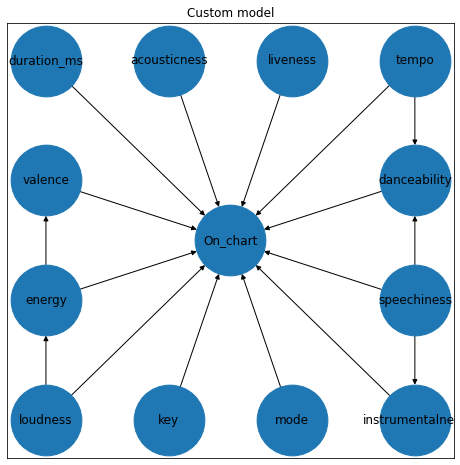

In [8]:
custom_model = BayesianModel([('tempo', 'danceability'), ('loudness', 'energy'),
                              ('speechiness', 'danceability'), ('speechiness', 'instrumentalness'),
                              ('energy', 'valence'),
                              ('duration_ms', 'On_chart'), ('energy', 'On_chart'),
                              ('key', 'On_chart'), ('mode', 'On_chart'),
                              ('acousticness', 'On_chart'), ('danceability', 'On_chart'),
                              ('instrumentalness', 'On_chart'), ('liveness', 'On_chart'),
                              ('loudness', 'On_chart'), ('speechiness', 'On_chart'),
                              ('valence', 'On_chart'), ('tempo', 'On_chart')])
pos = {'duration_ms': [-1.5, 2], 'acousticness': [-0.5, 2], 'liveness': [0.5, 2], 'tempo': [1.5,  2],
       'valence': [-1.5,  1.5], 'energy': [-1.5, 1], 'loudness': [-1.5, 0.5],
       'danceability': [1.5, 1.5], 'speechiness': [1.5,  1], 'instrumentalness': [1.5, 0.5],
       'On_chart': [0, 1.25],
       'key': [-0.5, 0.5], 'mode': [0.5, 0.5]}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(custom_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Custom model')
fig.savefig('custom_bn')

## Learning the network structure

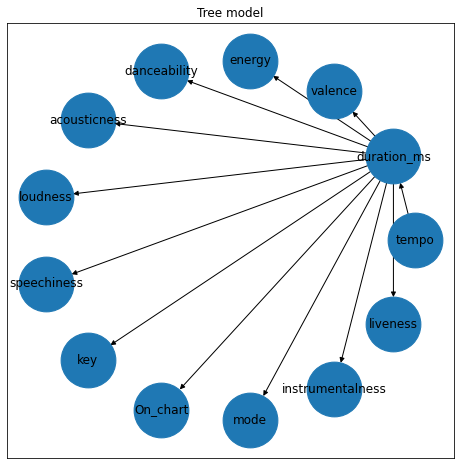

In [9]:
ts = TreeSearch(data=data, root_node='tempo')
tree_model = ts.estimate(show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=3000)
fig.savefig('tree')
ax.set_title('Tree model')
tree_model = BayesianModel(tree_model.edges())

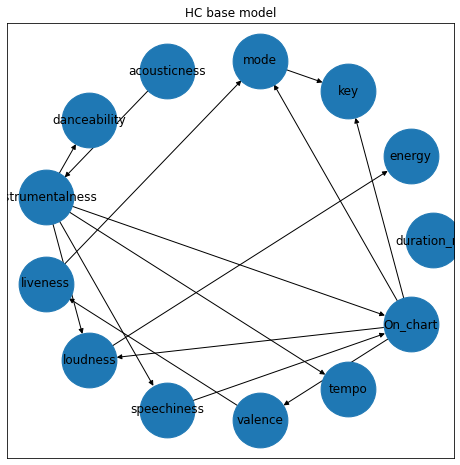

In [10]:
scorer = BDeuScore(data=data)
hc = HillClimbSearch(data=data)
hc_base_model = hc.estimate(scoring_method=scorer, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(hc_base_model, pos=nx.drawing.layout.circular_layout(hc_base_model), ax=ax, node_size=3000)
fig.savefig('hc_base')
ax.set_title('HC base model')
hc_base_model = BayesianModel(hc_base_model.edges())

In [1]:
mandatory = [('tempo', 'danceability'), ('loudness', 'energy')]
black_list = [(c, 'On_chart') for c in data.columns]

scorer = BDeuScore(data=data)
hc = HillClimbSearch(data=data)
hc_constr_model = hc.estimate(scoring_method=scorer, fixed_edges=mandatory, black_list=black_list, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(hc_constr_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax, node_size=3000)
fig.savefig('hc_constrained')
ax.set_title('HC constrained model')
hc_constr_model = BayesianModel(hc_constr_model.edges())

NameError: ignored